In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter compatibility
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches  # For drawing patch borders
import time
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Configuration Section
config = {
    'random_seed': 42,
    'np_seed': 0,
    'torch_seed': 0,
    'torch_manual_seed': 2147483647,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'data_norm_path': '/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_train_02292024.npy',
    'data_yield_path': '/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_yield_train.npy',
    'batch_size': 64,
    'num_workers': 4,
    'num_epochs': 10,
    'img_size': (216, 8),
    'patch_size': 8,
    'embed_dim': 128,
    'depth': 12,
    'num_heads': 4,
    'learning_rate': 0.001,
    'optimizer': 'adam',  # Options: 'adam', 'sgd', etc.
    'loss_function': 'mse',  # Options: 'mse', 'mae', etc.
    'print_interval': 100,  # Print loss every 100 batches
    'num_samples': 100,  # Number of samples for importance analysis
    'log_dir': './logs'  # Directory for TensorBoard logs
}

# Generate a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Format the run name
run_name = f"run_{timestamp}_opt_{config['optimizer']}_loss_{config['loss_function']}_lr_{config['learning_rate']}"

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=f"{config['log_dir']}/{run_name}")

# Setting the seeds for reproducibility
np.random.seed(config['np_seed'])
torch.manual_seed(config['torch_seed'])
random.seed(config['random_seed'])
g = torch.Generator().manual_seed(config['torch_manual_seed'])  # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check for device
device = config['device']
print("Device:", device)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # Change here: make sure to use batch_first=True in the transformer encoder
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, depth, num_heads):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)  # in_channels set to 1 for grayscale
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)  # Output a single value for regression
        )

    def forward(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer_encoder(x)
        x = self.regression_head(x[:, 0])
        return x

    def get_attention_maps(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        attention_maps = []
        for layer in self.transformer_encoder.layers:
            x = layer.norm1(x)
            attention = layer.self_attn(x, x, x, need_weights=True)[1]
            attention_maps.append(attention.detach().cpu())
            x = layer.self_attn(x, x, x)[0] + x
            x = layer.norm2(x)
            x = layer.linear2(layer.dropout(layer.activation(layer.linear1(x)))) + x
        return attention_maps

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        label = self.labels_tensor[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Function to pad the image to the nearest multiple of patch_size_h and patch_size_w
def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w

    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image

# Define any required transformations
transform = transforms.Compose([
    # Add any transformations you need here
])

# Load and preprocess data
data = np.load(config['data_norm_path'])
data_tensor = torch.from_numpy(data).float()  # Convert to float
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor = data_tensor.unsqueeze(1)
data_tensor = pad_image(data_tensor, config['img_size'][0], config['img_size'][1])  # Pad to [batch_size, 1, 216, 8]

labels = np.load(config['data_yield_path'])
label_tensor = torch.from_numpy(labels).float()  # Convert to float

# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data_tensor, label_tensor, test_size=0.4, random_state=config['random_seed'])
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=config['random_seed'])

train_dataset = CustomTensorDataset(data_tensor=train_data, labels_tensor=train_labels, transform=transform)
val_dataset = CustomTensorDataset(data_tensor=val_data, labels_tensor=val_labels, transform=transform)
test_dataset = CustomTensorDataset(data_tensor=test_data, labels_tensor=test_labels, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], generator=g)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], generator=g)

# Initialize model, loss function, and optimizer
model = VisionTransformer(
    img_size=config['img_size'],
    patch_size=config['patch_size'],
    embed_dim=config['embed_dim'],
    depth=config['depth'],
    num_heads=config['num_heads']
).to(device)

# Set up the optimizer
if config['optimizer'] == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
elif config['optimizer'] == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])
else:
    raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

# Set up the loss function
if config['loss_function'] == 'mse':
    criterion = nn.MSELoss()
elif config['loss_function'] == 'mae':
    criterion = nn.L1Loss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_function']}")

# Function to convert seconds to hours, minutes, and seconds
def convert_seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return hours, minutes, seconds

# Training loop
num_epochs = config['num_epochs']
prev_val_loss = float('inf')

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (inputs, targets) in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Ensure targets have shape [batch_size, 1]
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % config['print_interval'] == 0:  # Print every config['print_interval'] batches
            tqdm.write(f"  Batch {i+1}/{len(train_dataloader)}, Training Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_dataloader)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_dataloader, desc="Validation", leave=False)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Ensure targets have shape [batch_size, 1]
            val_loss += loss.item()

            if (i + 1) % config['print_interval'] == 0:  # Print every config['print_interval'] batches
                tqdm.write(f"  Batch {i+1}/{len(val_dataloader)}, Validation Loss: {loss.item():.4f}")
    
    avg_val_loss = val_loss / len(val_dataloader)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    gain = prev_val_loss - avg_val_loss
    prev_val_loss = avg_val_loss

    # Print epoch performance
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Gain: {gain:.4f}")

end_time = time.time()
total_time = end_time - start_time
hours, minutes, seconds = convert_seconds_to_hms(total_time)
print(f"Total training time: {hours} hours, {minutes} minutes, {seconds} seconds")

# Testing loop
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader, desc="Testing", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Ensure targets have shape [batch_size, 1]
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')
writer.add_scalar('Loss/Test', avg_test_loss)

# Close the TensorBoard writer
writer.close()




Device: cuda:0
Epoch 1/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0153
  Batch 200/873, Training Loss: 0.0110
  Batch 300/873, Training Loss: 0.0115
  Batch 400/873, Training Loss: 0.0121
  Batch 500/873, Training Loss: 0.0139
  Batch 600/873, Training Loss: 0.0123
  Batch 700/873, Training Loss: 0.0133
  Batch 800/873, Training Loss: 0.0092


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 200/291, Validation Loss: 0.0129
Epoch [1/10], Training Loss: 0.0482, Validation Loss: 0.0116, Gain: inf
Epoch 2/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0141
  Batch 200/873, Training Loss: 0.0118
  Batch 300/873, Training Loss: 0.0141
  Batch 400/873, Training Loss: 0.0148
  Batch 500/873, Training Loss: 0.0067
  Batch 600/873, Training Loss: 0.0110
  Batch 700/873, Training Loss: 0.0106
  Batch 800/873, Training Loss: 0.0114


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0130
  Batch 200/291, Validation Loss: 0.0126
Epoch [2/10], Training Loss: 0.0118, Validation Loss: 0.0119, Gain: -0.0003
Epoch 3/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0097
  Batch 200/873, Training Loss: 0.0147
  Batch 300/873, Training Loss: 0.0082
  Batch 400/873, Training Loss: 0.0150
  Batch 500/873, Training Loss: 0.0094
  Batch 600/873, Training Loss: 0.0096
  Batch 700/873, Training Loss: 0.0106
  Batch 800/873, Training Loss: 0.0129


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0129
  Batch 200/291, Validation Loss: 0.0127
Epoch [3/10], Training Loss: 0.0116, Validation Loss: 0.0118, Gain: 0.0001
Epoch 4/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0102
  Batch 200/873, Training Loss: 0.0126
  Batch 300/873, Training Loss: 0.0094
  Batch 400/873, Training Loss: 0.0122
  Batch 500/873, Training Loss: 0.0115
  Batch 600/873, Training Loss: 0.0097
  Batch 700/873, Training Loss: 0.0096
  Batch 800/873, Training Loss: 0.0112


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0128
  Batch 200/291, Validation Loss: 0.0127
Epoch [4/10], Training Loss: 0.0116, Validation Loss: 0.0117, Gain: 0.0001
Epoch 5/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0129
  Batch 200/873, Training Loss: 0.0074
  Batch 300/873, Training Loss: 0.0094
  Batch 400/873, Training Loss: 0.0119
  Batch 500/873, Training Loss: 0.0120
  Batch 600/873, Training Loss: 0.0096
  Batch 700/873, Training Loss: 0.0093
  Batch 800/873, Training Loss: 0.0138


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 200/291, Validation Loss: 0.0134
Epoch [5/10], Training Loss: 0.0116, Validation Loss: 0.0115, Gain: 0.0002
Epoch 6/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0082
  Batch 200/873, Training Loss: 0.0141
  Batch 300/873, Training Loss: 0.0145
  Batch 400/873, Training Loss: 0.0125
  Batch 500/873, Training Loss: 0.0102
  Batch 600/873, Training Loss: 0.0124
  Batch 700/873, Training Loss: 0.0150
  Batch 800/873, Training Loss: 0.0107


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0128
  Batch 200/291, Validation Loss: 0.0127
Epoch [6/10], Training Loss: 0.0117, Validation Loss: 0.0117, Gain: -0.0002
Epoch 7/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0097
  Batch 200/873, Training Loss: 0.0096
  Batch 300/873, Training Loss: 0.0116
  Batch 400/873, Training Loss: 0.0143
  Batch 500/873, Training Loss: 0.0109
  Batch 600/873, Training Loss: 0.0097
  Batch 700/873, Training Loss: 0.0103
  Batch 800/873, Training Loss: 0.0099


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 200/291, Validation Loss: 0.0128
Epoch [7/10], Training Loss: 0.0116, Validation Loss: 0.0116, Gain: 0.0001
Epoch 8/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0127
  Batch 200/873, Training Loss: 0.0162
  Batch 300/873, Training Loss: 0.0111
  Batch 400/873, Training Loss: 0.0100
  Batch 500/873, Training Loss: 0.0134
  Batch 600/873, Training Loss: 0.0091
  Batch 700/873, Training Loss: 0.0110
  Batch 800/873, Training Loss: 0.0115


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0133
  Batch 200/291, Validation Loss: 0.0126
Epoch [8/10], Training Loss: 0.0115, Validation Loss: 0.0122, Gain: -0.0006
Epoch 9/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0112
  Batch 200/873, Training Loss: 0.0112
  Batch 300/873, Training Loss: 0.0106
  Batch 400/873, Training Loss: 0.0161
  Batch 500/873, Training Loss: 0.0127
  Batch 600/873, Training Loss: 0.0099
  Batch 700/873, Training Loss: 0.0100
  Batch 800/873, Training Loss: 0.0141


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 200/291, Validation Loss: 0.0132
Epoch [9/10], Training Loss: 0.0115, Validation Loss: 0.0115, Gain: 0.0007
Epoch 10/10


Training:   0%|          | 0/873 [00:00<?, ?it/s]

  Batch 100/873, Training Loss: 0.0068
  Batch 200/873, Training Loss: 0.0145
  Batch 300/873, Training Loss: 0.0132
  Batch 400/873, Training Loss: 0.0119
  Batch 500/873, Training Loss: 0.0109
  Batch 600/873, Training Loss: 0.0104
  Batch 700/873, Training Loss: 0.0127
  Batch 800/873, Training Loss: 0.0134


Validation:   0%|          | 0/291 [00:00<?, ?it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 200/291, Validation Loss: 0.0131
Epoch [10/10], Training Loss: 0.0115, Validation Loss: 0.0115, Gain: -0.0000
Total training time: 0.0 hours, 4.0 minutes, 4.268916368484497 seconds


Testing:   0%|          | 0/291 [00:00<?, ?it/s]

Test Loss: 0.0112


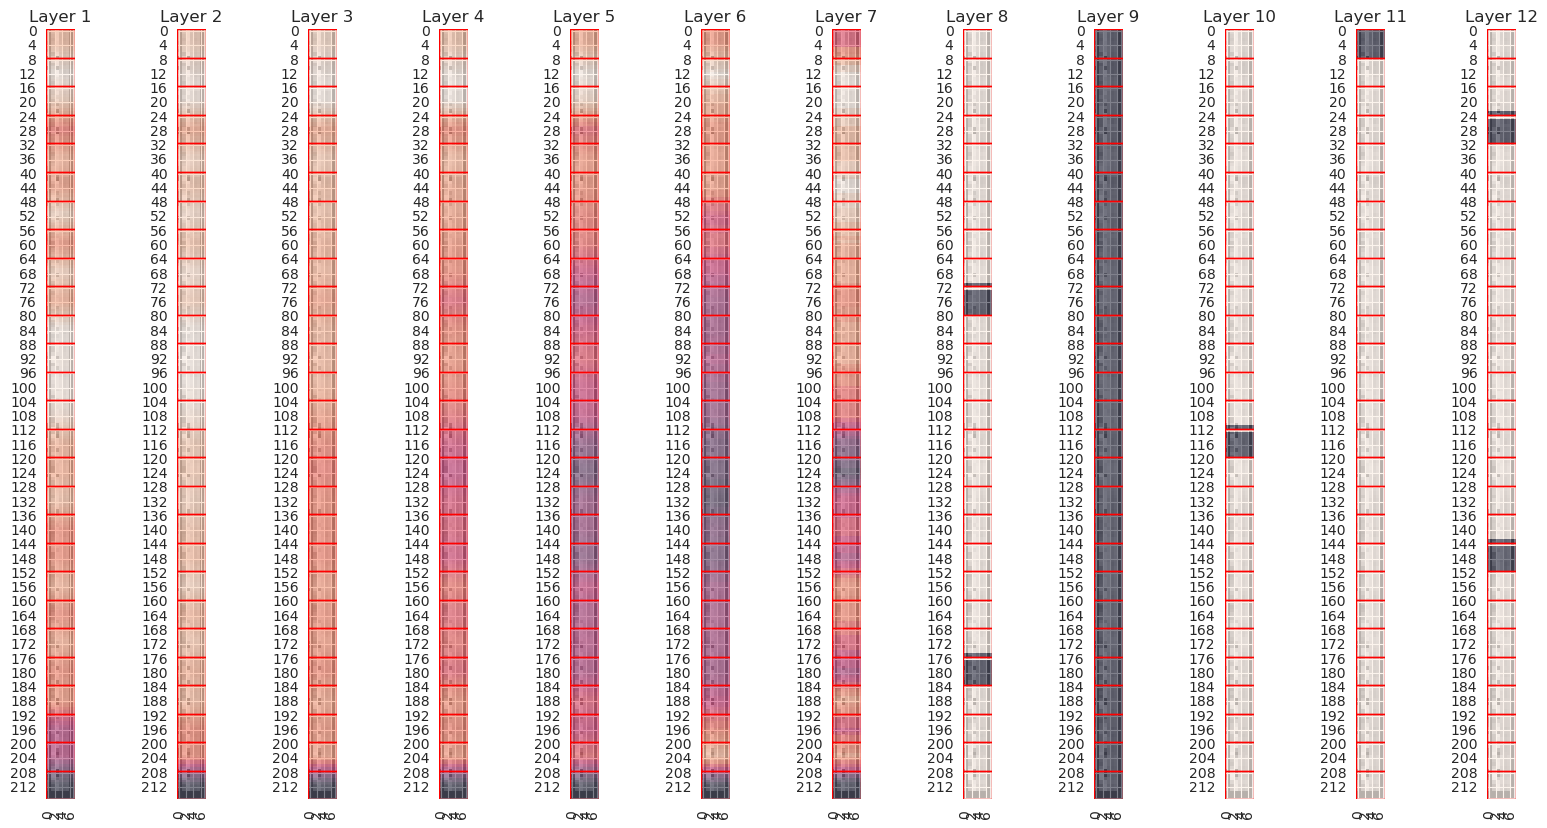

In [31]:
# Select random sample of 100 datapoints for attention analysis
np.random.seed(config['random_seed'])
random_indices = np.random.choice(len(test_dataset), config['num_samples'], replace=False)
random_sample = Subset(test_dataset, random_indices)

# Initialize accumulators for attention maps
accumulated_attention_maps = None

# Collect attention maps
for i in tqdm(range(len(random_sample)), desc="Collecting Attention Maps"):
    image, label = random_sample[i]
    image = image.unsqueeze(0).to(device)
    attention_maps = model.get_attention_maps(image)
    
    if accumulated_attention_maps is None:
        accumulated_attention_maps = [attn_map[0, 0, 1:].reshape(-1).cpu().numpy() for attn_map in attention_maps]
    else:
        for j in range(len(attention_maps)):
            accumulated_attention_maps[j] += attention_maps[j][0, 0, 1:].reshape(-1).cpu().numpy()

# Normalize accumulated attention maps
for j in range(len(accumulated_attention_maps)):
    accumulated_attention_maps[j] /= config['num_samples']

# Visualize aggregated attention maps on a representative image
single_image, _ = test_dataset[random_indices[0]]
single_image = single_image.unsqueeze(0).to(device)

def plot_aggregated_attention_maps(image, accumulated_attention_maps, patch_size):
    image = image.squeeze(0).cpu().numpy()  # Remove batch dimension
    image = image.transpose(1, 2, 0).squeeze()  # Change shape from [1, H, W] to [H, W]

    fig, axes = plt.subplots(1, len(accumulated_attention_maps), figsize=(20, 10))
    num_patches = (image.shape[0] // patch_size) * (image.shape[1] // patch_size)
    for i, attn_map in enumerate(accumulated_attention_maps):
        attn_map = attn_map.reshape(image.shape[0] // patch_size, image.shape[1] // patch_size)
        attn_map = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=image.shape, mode='bilinear').squeeze().cpu().numpy()
        
        # Normalize attention map for better visualization
        attn_map /= attn_map.max()
        
        # Overlay the attention map on the original image
        axes[i].imshow(image, cmap='gray', alpha=0.5)  # Original image in grayscale
        sns.heatmap(attn_map, ax=axes[i], cbar=False, alpha=0.5)  # Attention map overlay
        axes[i].set_title(f'Layer {i+1}')
        
        # Draw patch borders
        for y in range(0, image.shape[0], patch_size):
            for x in range(0, image.shape[1], patch_size):
                rect = patches.Rectangle((x, y), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
                
    plt.show()

# Example usage
plot_aggregated_attention_maps(single_image, accumulated_attention_maps, config['patch_size'])



In [32]:
start_time = time.time()

def ablation_study(model, dataloader, criterion, device):
    """
    Conducts an ablation study by evaluating the model with specific layers excluded.
    """
    original_state_dict = model.state_dict()
    performance_metrics = {}
    
    for layer in range(len(model.transformer_encoder.layers)):
        model.load_state_dict(original_state_dict)  # Reset model to original state
        new_layers = nn.ModuleList([model.transformer_encoder.layers[i] for i in range(len(model.transformer_encoder.layers)) if i != layer])
        model.transformer_encoder = nn.TransformerEncoder(new_layers, num_layers=len(new_layers))
        
        # Evaluate the model
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item()
        
        avg_loss = running_loss / len(dataloader)
        performance_metrics[f'Layer_{layer}'] = avg_loss
        print(f'Layer {layer} excluded: Avg Loss = {avg_loss}')
    
    return performance_metrics

# Conduct ablation study
performance_metrics = ablation_study(model, val_dataloader, criterion, device)

end_time = time.time()
total_time = end_time - start_time
hours, minutes, seconds = convert_seconds_to_hms(total_time)
print(f"Performance analysis time: {hours} hours, {minutes} minutes, {seconds} seconds")

/home/jiztom/anaconda3/envs/image-based-transformer/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


AttributeError: 'ModuleList' object has no attribute 'self_attn'